In [34]:
import numba
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit
import scipy
from scipy.spatial.transform import Rotation as Rot
import Swimmer
plt.rc('text', usetex=True)
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [35]:
T=1
R=1
a = 10*R
epsilons = np.linspace(0.1,5,50)*R

steps = 1000
nsteps = 1000
dt = T/steps
#initial positions 
r0 = np.array([[0, 0, 0],
[0, 0, a],
[a*np.sqrt(8)/3, 0 , -a/3],
[-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
[-a*np.sqrt(8)/6, -a*np.sqrt(24)/6, -a/3]])

In [36]:
def getR0(ls):
    a1,a2,a3,a4 = ls
    
    R0 = [[0, 0, 0],
    [0, 0, a1],
    [a2*np.sqrt(8)/3, 0 , -a2/3],
    [-a3*np.sqrt(8)/6, a3*np.sqrt(24)/6 , -a3/3],
    [-a4*np.sqrt(8)/6, -a4*np.sqrt(24)/6, -a4/3]]
    
    return np.array(R0)

In [37]:
@njit
def getDistanceMatrix(A):   # dij = rj - ri
    tiledPoses = tile(A)
    distances = tiledPoses - tiledPoses.transpose((1,0,2))
    return distances

In [38]:
@njit
def tile(x):
    tiled = np.zeros((5,5,3))
    for i in range(5):
        tiled[i,:,:] = x
        
    return tiled


In [39]:
@njit
def tile2(x):
    tiled = np.zeros((5,5,3,3))
    for i in range(3):
        for j in range(3):
            tiled[:,:,i,j] = x
        
    return tiled

In [40]:
@njit
def getO(d):
    d2 = d**2    
    drNorm = np.sum(d2,axis=2)**0.5
            
    
    I5_5_3_3 = np.zeros((5,5,3,3))

    for i in range(5):
        for j in range(5):
            I5_5_3_3[i,j,:,:] = np.eye(3)

    c1 = d.reshape(5,5,3,1)
    c2 = c1.transpose(0,1,3,2)    
    B = np.multiply(c1,c2)    
    c3 = tile2(drNorm)


    O = R*(I5_5_3_3 + B/(c3**2))*0.75/c3 #*R/norm(l)
    
    for i in range(5):  #for i=j
        O[i,i,:,:] = np.eye(3)

    return O

In [41]:
@njit
def getRR(r):
    rr0 = np.array([
    
    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]])
    
    
    rr1 = np.array([[0, -r[0,2] , r[0,1],  0, -r[1,2] , r[1,1],    0, -r[2,2] , r[2,1], 0, -r[3,2] , r[3,1]   ,0, -r[4,2] , r[4,1]],
    [r[0,2], 0 , -r[0,0],   r[1,2], 0 , -r[1,0],  r[2,2], 0 , -r[2,0],  r[3,2], 0 , -r[3,0],  r[4,2], 0 , -r[4,0]],
    [-r[0,1], r[0,0], 0 , -r[1,1], r[1,0], 0 , -r[2,1], r[2,0], 0 ,   -r[3,1], r[3,0], 0 ,  -r[4,1], r[4,0], 0 ]])
    
    


    
    return np.concatenate((rr0,rr1),axis=0)

In [42]:
@njit
def getOO(d):
    ##Check
    k2_3 = np.dot(d[1,0],d[1,0])*np.dot(d[2,0],d[2,0])/np.dot(d[1,0],d[2,0])
    k2_4 = np.dot(d[1,0],d[1,0])*np.dot(d[3,0],d[3,0])/np.dot(d[1,0],d[3,0])
    k2_5 = np.dot(d[1,0],d[1,0])*np.dot(d[4,0],d[4,0])/np.dot(d[1,0],d[4,0])
    k3_4 = np.dot(d[2,0],d[2,0])*np.dot(d[3,0],d[3,0])/np.dot(d[2,0],d[3,0])
    k3_5 = np.dot(d[2,0],d[2,0])*np.dot(d[4,0],d[4,0])/np.dot(d[2,0],d[4,0])

    p2_3 = np.dot(d[2,0],d[2,0])*d[0,1] - k2_3*d[0,2] 
    p2_4 = np.dot(d[3,0],d[3,0])*d[0,1] - k2_4*d[0,3] 
    p2_5 = np.dot(d[4,0],d[4,0])*d[0,1] - k2_5*d[0,4] 
    p3_4 = np.dot(d[3,0],d[3,0])*d[0,2] - k3_4*d[0,3] 
    p3_5 = np.dot(d[4,0],d[4,0])*d[0,2] - k3_5*d[0,4] 


    q2_3 = np.dot(d[1,0],d[1,0])*d[0,2] - k2_3*d[0,1] 
    q2_4 = np.dot(d[1,0],d[1,0])*d[0,3] - k2_4*d[0,1] 
    q2_5 = np.dot(d[1,0],d[1,0])*d[0,4] - k2_5*d[0,1] 
    q3_4 = np.dot(d[2,0],d[2,0])*d[0,3] - k3_4*d[0,2] 
    q3_5 = np.dot(d[2,0],d[2,0])*d[0,4] - k3_5*d[0,2] 
    
    
    OO = np.array([
        [d[1,0,0], d[1,0,1], d[1,0,2], -d[1,0,0], -d[1,0,1], -d[1,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [d[2,0,0], d[2,0,1], d[2,0,2], 0, 0, 0, -d[2,0,0], -d[2,0,1], -d[2,0,2], 0, 0, 0, 0, 0, 0,   ],   
    [d[3,0,0], d[3,0,1], d[3,0,2], 0, 0, 0, 0, 0, 0, -d[3,0,0], -d[3,0,1], -d[3,0,2], 0, 0, 0],
    [d[4,0,0], d[4,0,1], d[4,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0, -d[4,0,0], -d[4,0,1], -d[4,0,2]],
    
    [-p2_3[0] -q2_3[0], -p2_3[1] -q2_3[1], -p2_3[2] -q2_3[2],                p2_3[0], p2_3[1], p2_3[2], q2_3[0], q2_3[1], q2_3[2], 0, 0, 0, 0, 0, 0], #2_3,
    [-p2_4[0] -q2_4[0], -p2_4[1] -q2_4[1], -p2_4[2] -q2_4[2],                p2_4[0], p2_4[1], p2_4[2], 0, 0, 0, q2_4[0], q2_4[1], q2_4[2], 0, 0, 0],  #2_4,
    [-p2_5[0] -q2_5[0], -p2_5[1] -q2_5[1], -p2_5[2] -q2_5[2],                p2_5[0], p2_5[1], p2_5[2], 0, 0, 0, 0, 0, 0, q2_5[0], q2_5[1], q2_5[2]], #2_5
    [-p3_4[0] -q3_4[0], -p3_4[1] -q3_4[1], -p3_4[2] -q3_4[2],                0, 0, 0, p3_4[0], p3_4[1], p3_4[2], q3_4[0], q3_4[1], q3_4[2], 0, 0, 0],  #3_4
    [-p3_5[0] -q3_5[0], -p3_5[1] -q3_5[1], -p3_5[2] -q3_5[2],                0, 0, 0, p3_5[0], p3_5[1], p3_5[2], 0, 0, 0, q3_5[0], q3_5[1], q3_5[2]] #3_5
    
    ])
    
    return OO


In [43]:
@njit
def getC(l,u):
    lu = np.zeros(4)
    for i in range(4):
        lu[i]= (l[i]*u[i])
        
    
    return np.array([*list(lu), 0,0,0,0,0,0,0,0, 0,0,0])  

#  u -> u/steps maybe

In [44]:
def getV(r,l,u):
    d = getDistanceMatrix(r)

    O = getO(d)
    newO = np.zeros((15,15))
    for i in range(5):
        for j in range(5):
            newO[3*i:3*i+3,3*j:3*j+3] = O[i,j]
        
    rr= getRR(r)
    mm = np.linalg.inv(newO)


    NN = np.matmul(rr,mm)
    OO = getOO(d)
    AA = np.concatenate((OO,NN),axis=0)
    
    
    

    BB = getC(l,u)
    
    return np.linalg.solve(AA,BB)
        
        
        

In [45]:
def step(r,L):
    for t in range(nsteps):
        try:
            U = L[:,t+1]-L[:,t]
        except IndexError:
            U = L[:,t]-L[:,t-1]
            
        v = getV(r,L[:,t],U).reshape((5,3))
        
        r += v  ##########
        
        
    return r    

In [ ]:
def act(L):
    r = getR0(L[:,0])
    r_final = step(r.copy(),L)
    delta = list(r_final - r)[0]
    return r_final,delta,np.matmul(getE(r_final), np.linalg.inv(getE(r)))

In [47]:
def getE(r):
    e1 = ((r[1]-r[0])/np.linalg.norm((r[1]-r[0]))).reshape((3,1))
    e2 = ((r[2]-r[0])/np.linalg.norm((r[2]-r[0]))).reshape((3,1))
    e3 = ((r[3]-r[0])/np.linalg.norm((r[3]-r[0]))).reshape((3,1))
    
    return np.concatenate((e1,e2,e3),axis=1)
    

### Saving Data for epsilon = 3 

In [ ]:
@njit
def getAction(state,ratio):
    #t=1 if state=0 and t = ratio if state = 1   ???
    t1,t2,t3,t4 = np.where(state==0,1,ratio)
    sum = t1*t2*t3 + t1*t2*t4 + t1*t3*t4 + t2*t3*t4
    #probs = np.array([t2*t3*t4/sum,t1*t3*t4/sum,t1*t2*t4/sum,t2*t3*t1/sum])
    randomNumber = np.random.uniform(0,1,1)
    if randomNumber <= t4*t2*t3/sum:
        changingJoint = 0
    elif(randomNumber <= (t4*t3*t1+t4*t2*t3)/sum):  
        changingJoint = 1
    elif randomNumber <= (t4*t2*t1+t4*t2*t3+t4*t3*t1)/sum:
        changingJoint = 2
    else:
        changingJoint = 3



    return changingJoint,getDeltat2(t1,t2,t3,t4)


@njit
def doStep(Data,state,ratio):
    action,deltat = getAction(state,ratio)
    new_state = state.copy()
    new_state[action] = 1 - new_state[action]
    delta = Data[fromBinary(state)*4 + action][0,:]  #???
    rotation = Data[fromBinary(state)*4 + action][1:,:]
    return new_state,delta,rotation,deltat


In [49]:
states = np.zeros((10,4),dtype=np.int64)


In [50]:
@njit
def getDeltat(t1,t2,t3,t4,tc):
    tav = 18.844
    return ((1-1/(tav*t1))*(1-1/(tav*t2))*(1-1/(tav*t3))*(1-1/(tav*t4))*tav/tc)/(((1/t1 + 1/t2 + 1/t3 + 1/t4)**2)*(1-1/(tav*tc)))

In [51]:
@njit
def getDeltat2(t1,t2,t3,t4):
    return 1/(1/t1 + 1/t2 + 1/t3 + 1/t4)

## P(t1,t2,t3,t4) = t2*t3*t4/(t1*t2*t3 + t1*t2*t4 + t1*t3*t4 + t2*t3*t4)

In [52]:
@njit
def getBinary(int: a):
    return np.array([int//8,(int%8)//4,(int%4)//2,int%2])
@njit 
def fromBinary(binary):
    x = 0
    for i in range(len(binary)):
        x += binary[::-1][i]*(2**i)
    return x

@njit 
def fromBinary2d(binaries):
    x = np.zeros(binaries.shape[0],dtype=np.int64)
    for i in range(binaries.shape[0]):
        x[i] = fromBinary(binaries[i])
    return x

In [53]:
def getAllPossibleActions(a,epsilon,steps):
    
    closing = a - np.arange(steps+1)*epsilon/steps
    closed = (a-epsilon)*np.ones(steps+1)
    opening = a - epsilon + np.arange(steps+1)*epsilon/steps
    opened  = a *np.ones(steps+1)
    
    possibleActions = np.zeros((64,4,steps+1))
    
    
    
    for i in range(16):
        for j in range(4):
            actionBinaryState = getBinary(i)
            # closed for 0 and opened for 1 
            ca = np.array([closed,closed,closed,closed])*actionBinaryState.reshape(4,1) + np.array([opened,opened,opened,opened])*(1-actionBinaryState).reshape(4,1)
            if actionBinaryState[j] == 0:
                ca[j,:] = opening
            else:
                ca[j,:] = closing
                
            possibleActions[4*i+j] = ca 
        
    return possibleActions

In [80]:
epsilon = 3
allPossbileActions = getAllPossibleActions(a,epsilon, steps)
np.save("allPossbileActions",allPossbileActions)

In [54]:
allPossbileActions = np.load("allPossbileActions.npy")

## Data Collection for epsilon = 3

In [82]:
actionsData = np.zeros((64,4,3))

for i in range(64):
    print(i)
    _,delta,Rotation = act(allPossbileActions[i])
    actionsData[i,0,:] = delta
    actionsData[i,1:4,:] = Rotation
    
np.save("actionDatasForE=3",actionsData)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [55]:
actionsData = np.load("actionDatasForE=3.npy")

In [56]:
@njit
def perturbe(Data,perturbingSteps,ratio):
    time = 0
    pertrubingPose = np.array([0.,0.,0.])
    perturbingRotation = np.eye(3)
    state = np.ones(4,dtype=np.int64)
    pertrubingPoses = np.zeros((perturbingSteps,3))
    pertrubingTimes = np.zeros(perturbingSteps)
        
    for t in range(perturbingSteps):
        newState,delta,rotation,deltat = doStep(Data,state,ratio)
        state = newState
        pertrubingPose += perturbingRotation @ delta
        perturbingRotation = rotation @ perturbingRotation
        pertrubingPoses[t] = pertrubingPose
        time += deltat
        pertrubingTimes[t] = time
        
    return pertrubingPoses,pertrubingTimes

In [57]:
perturbe(actionsData,1000,1)

(array([[ 4.37962714e-18,  4.49481998e-18,  5.57630488e-01],
        [-2.63008484e-01,  4.55544056e-01,  3.74065100e-01],
        [-5.27876500e-01,  7.34256847e-03,  1.90266624e-01],
        ...,
        [-1.89362601e-01, -2.12262708e-02,  1.32324864e-01],
        [ 2.95639807e-01, -1.58359970e-01, -1.06225114e-01],
        [ 3.67840523e-01, -1.14676477e-01,  4.44481143e-01]]),
 array([  0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,   2.  ,
          2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,   4.  ,
          4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,   6.  ,
          6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,   8.  ,
          8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,  10.  ,
         10.25,  10.5 ,  10.75,  11.  ,  11.25,  11.5 ,  11.75,  12.  ,
         12.25,  12.5 ,  12.75,  13.  ,  13.25,  13.5 ,  13.75,  14.  ,
         14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,  16.  ,
         16.25,  16.5 ,  16.75,  17.  ,  17

In [ ]:
@njit
def getPerturbingDiffusionCoefForRatio(Data,ratio,iterations=1000,perturbingSteps=1000):
    # iterations = 10_00
    # perturbingSteps = 10_00
    meanFinalPoses = np.zeros((perturbingSteps))
    meanFinalTimes = np.zeros(perturbingSteps)
    for iteration in range(iterations):
        pertrubingPoses,pertrubingTimes = perturbe(Data,perturbingSteps,ratio)
        meanFinalTimes += pertrubingTimes
     
    return meanFinalTimes/iterations,meanFinalPoses/iterations

def getPerturbingDiffusionCoef(Data,ratios,iterations=1000,perturbingSteps=1000):
    diffs =np.zeros(ratios.shape)
    for i in range(ratios.shape[0]):
        print(i)
        meanFinalTimes,meanFinalPoses= getPerturbingDiffusionCoefForRatio(Data,ratios[i],iterations,perturbingSteps)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(meanFinalTimes,meanFinalPoses)
        diffs[i] =  slope 
    return diffs


In [59]:
getPerturbingDiffusionCoefForRatio(actionsData,1)

(array([  0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,   2.  ,
          2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,   4.  ,
          4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,   6.  ,
          6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,   8.  ,
          8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,  10.  ,
         10.25,  10.5 ,  10.75,  11.  ,  11.25,  11.5 ,  11.75,  12.  ,
         12.25,  12.5 ,  12.75,  13.  ,  13.25,  13.5 ,  13.75,  14.  ,
         14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,  16.  ,
         16.25,  16.5 ,  16.75,  17.  ,  17.25,  17.5 ,  17.75,  18.  ,
         18.25,  18.5 ,  18.75,  19.  ,  19.25,  19.5 ,  19.75,  20.  ,
         20.25,  20.5 ,  20.75,  21.  ,  21.25,  21.5 ,  21.75,  22.  ,
         22.25,  22.5 ,  22.75,  23.  ,  23.25,  23.5 ,  23.75,  24.  ,
         24.25,  24.5 ,  24.75,  25.  ,  25.25,  25.5 ,  25.75,  26.  ,
         26.25,  26.5 ,  26.75,  27.  ,  27.25,  27.5 ,  27.75, 

In [60]:
ratios = np.exp(np.linspace(-5,5,50))

## Oriented randomwalk

In [ ]:
@njit
def getOrientedAction(state,ratio,rotation,grad):

    ratios = ratio + np.dot((rotation @ (r0[1:].T)).T,grad)   # WRONG, some joints are smaller depending on the state. 

    
    t1,t2,t3,t4 = np.where(state==0,np.ones(4),ratios)
    
    sum = t1*t2*t3 + t1*t2*t4 + t1*t3*t4 + t2*t3*t4
    #probs = np.array([t2*t3*t4/sum,t1*t3*t4/sum,t1*t2*t4/sum,t2*t3*t1/sum])
    randomNumber = np.random.uniform(0,1,1)
    if randomNumber <= t4*t2*t3/sum:
        changingJoint = 0
    elif(randomNumber <= (t4*t3*t1+t4*t2*t3)/sum):  
        changingJoint = 1
    elif randomNumber <= (t4*t3*t1+t4*t2*t3+t4*t2*t1)/sum:
        changingJoint = 2
    else:
        changingJoint = 3

    # deltat = 1 if state[changingJoint]==0 else ratio
    return changingJoint,getDeltat2(t1,t2,t3,t4)

@njit
def doOrientedStep(Data,state,ratio,rotation,grad):
    action,deltat = getOrientedAction(state,ratio,rotation,grad)
    new_state = state.copy()
    new_state[action] = 1 - new_state[action]
    delta = Data[fromBinary(state)*4 + action][0,:]
    rotation = Data[fromBinary(state)*4 + action][1:,:]
    return new_state,delta,rotation,deltat

In [62]:
@njit
def Orientedperturbe(Data,perturbingSteps,ratio,grad):
    grad = ratio*np.array([0., 0., grad]) 
    time = 0
    pertrubingPose = np.array([0.,0.,0.])
    perturbingRotation = np.eye(3)
    state = np.ones(4,dtype=np.int64)
    pertrubingPoses = np.zeros((perturbingSteps,3))
    pertrubingTimes = np.zeros(perturbingSteps)
    angelData= np.zeros((perturbingSteps,3,3))

    for t in range(perturbingSteps):
        newState,delta,rotation,deltat = doOrientedStep(Data,state,ratio,perturbingRotation,grad)
        state = newState
        pertrubingPose += perturbingRotation @ delta
        perturbingRotation = rotation @ perturbingRotation
        pertrubingPoses[t] = pertrubingPose
        time += deltat
        pertrubingTimes[t] = time
        angelData[t] = perturbingRotation

    return pertrubingTimes,pertrubingPoses,angelData

In [179]:
2 / np.array([1,2,3])

array([2.        , 1.        , 0.66666667])

In [ ]:
def Orientedperturbe2(Data,perturbingSteps,ratio,grad):

    time = 0
    pertrubingPose = np.array([0.,0.,0.])
    perturbingRotation = np.eye(3)
    state = np.ones(4,dtype=np.int64)
    pertrubingPoses = np.zeros((perturbingSteps,3))
    pertrubingTimes = np.zeros(perturbingSteps)
    angelData= np.zeros((perturbingSteps,3,3))

    bait_pose  = np.array([0,0,20.0*R])
    bait_poses = np.zeros((perturbingSteps,3))

    distance = pertrubingPose - bait_pose
    # bait_spring_const = 0.01
    grad = -ratio * 0.001 * distance / np.linalg.norm(distance)








    for t in range(perturbingSteps):
        newState,delta,rotation,deltat = doOrientedStep(Data,state,ratio,perturbingRotation,+grad)
        state = newState
        pertrubingPose += perturbingRotation @ delta
        perturbingRotation = rotation @ perturbingRotation
        pertrubingPoses[t] = pertrubingPose
        time += deltat
        pertrubingTimes[t] = time
        angelData[t] = perturbingRotation



        # bait_pose = -distance * 20 / np.linalg.norm(distance) + pertrubingPose
        distance = pertrubingPose - bait_pose




        bait_pose += 0.001*np.dot(pertrubingPoses[t] - pertrubingPoses[t-1] , distance) * distance  / np.linalg.norm(distance)**2

        bait_poses[t] = bait_pose

        grad = -ratio * 0.001 * distance / np.linalg.norm(distance)

    return pertrubingTimes,pertrubingPoses,angelData,bait_poses



In [168]:
a,b,c,d = Orientedperturbe2(actionsData,50_000_000,2,0.001)
xdata , ydata, zdata  = b[:, 0], b[:, 1], b[:, 2]
print(xdata.min(),xdata.max())
print(ydata.min(),ydata.max())
print(zdata.min(),zdata.max())

-6.368520469089853 34.94673622026166
-5.61375870729669 49.93066111171996
-8.370393984695015 55.557604755142414


In [ ]:
data = (b.reshape((-1,3,1)) + c @ r0.T)
data.min(),data.max()

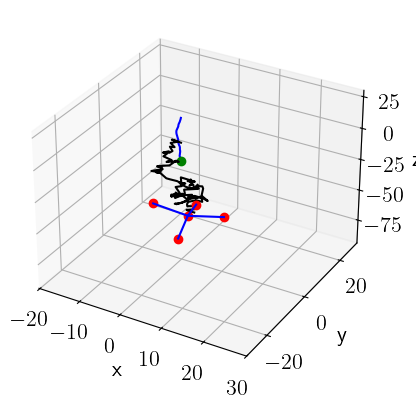

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
fig = plt.figure() 
ax = fig.add_subplot(projection="3d")
# ax.view_init(0,0)   # ? 
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

goto = 100

data = (b.reshape((-1,3,1)) + c @ r0.T)
bait_data= d[::int(data.shape[0]/goto)]
data = data[::int(data.shape[0]/goto)]


bait_path, = ax.plot([], [], [],"blue")
bait_mark, = ax.plot([], [], [],"go")

path, =ax.plot([], [], [],"black")
ln0, =ax.plot([], [], [],"ro")
ln1, =ax.plot([], [], [],"ro")
ln2, =ax.plot([], [], [],"ro")
ln3, =ax.plot([], [], [],"ro")
ln4, =ax.plot([], [], [],"ro")

j1, = ax.plot([], [], [],"b")
j2, = ax.plot([], [], [],"b")
j3, = ax.plot([], [], [],"b")
j4, = ax.plot([], [], [],"b")

def init():
    lim_factor = 1.5
    ax.set_xlim(lim_factor*min(data[:,0,:].min(),bait_data.min()),lim_factor*max(data[:,0,:].max(),bait_data.max()))
    ax.set_ylim(lim_factor*min(data[:,1,:].min(),bait_data.min()),lim_factor*max(data[:,1,:].max(),bait_data.max()))
    ax.set_zlim(lim_factor*min(data[:,2,:].min(),bait_data.min()),lim_factor*max(data[:,2,:].max(),bait_data.max()))
    return bait_path,bait_mark,path,ln0,ln1,ln2,ln3,ln4,j1,j2,j3,j4

def update(frame):
    bait_mark.set_data_3d([bait_data[frame,0]],[bait_data[frame,1]],[bait_data[frame,2]])
    path.set_data_3d(data[:frame,0,0],data[:frame,1,0],data[:frame,2,0])
    bait_path.set_data_3d(bait_data[:frame,0],bait_data[:frame,1],bait_data[:frame,2])
    

    ln0.set_data_3d([data[frame,0,0]],[data[frame,1,0]],[data[frame,2,0]])
    ln1.set_data_3d([data[frame,0,1]],[data[frame,1,1]],[data[frame,2,1]])
    ln2.set_data_3d([data[frame,0,2]],[data[frame,1,2]],[data[frame,2,2]])
    ln3.set_data_3d([data[frame,0,3]],[data[frame,1,3]],[data[frame,2,3]])
    ln4.set_data_3d([data[frame,0,4]],[data[frame,1,4]],[data[frame,2,4]])



    j1.set_data_3d([data[frame,0,1], data[frame,0,0]],[data[frame,1,1],data[frame,1,0]],[data[frame,2,1],data[frame,2,0]])
    j2.set_data_3d([data[frame,0,2], data[frame,0,0]],[data[frame,1,2],data[frame,1,0]],[data[frame,2,2],data[frame,2,0]])
    j3.set_data_3d([data[frame,0,3], data[frame,0,0]],[data[frame,1,3],data[frame,1,0]],[data[frame,2,3],data[frame,2,0]])
    j4.set_data_3d([data[frame,0,4], data[frame,0,0]],[data[frame,1,4],data[frame,1,0]],[data[frame,2,4],data[frame,2,0]])

    return bait_path,bait_mark,path,ln0,ln1,ln2,ln3,ln4,j1,j2,j3,j4

ani = FuncAnimation(fig, update , frames = np.arange(0, goto),init_func=init,blit = True, interval = 200)

ani.save("/home/astane/Desktop/PycharmProjects/UniProjects/swimmerProject/ani2.mp4")


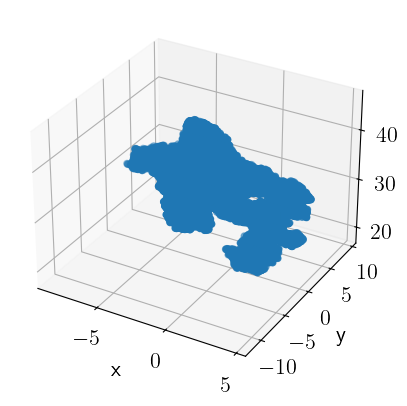

In [144]:
ax = plt.figure().add_subplot(projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
interval = 100
ax.scatter(xs=d[::interval, 0] - b[::interval,0], ys=d[::interval, 1] - b[::interval,1], zs=d[::interval, 2] - b[::interval,2])
plt.show()

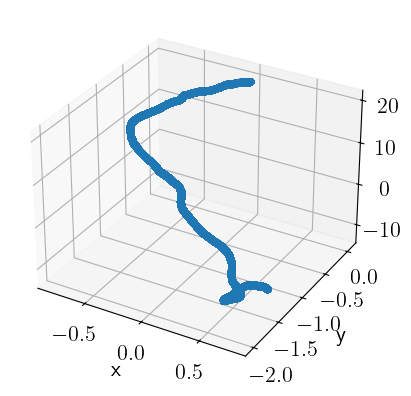

In [163]:
ax = plt.figure().add_subplot(projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(xs=d[::interval, 0], ys=d[::interval, 1], zs=d[::interval, 2])
plt.show()

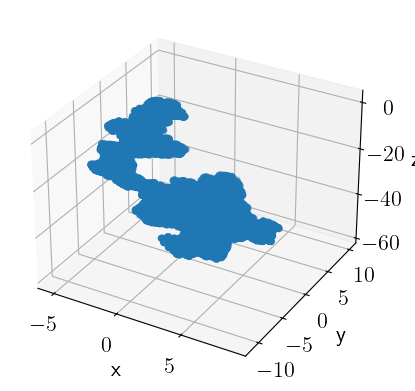

In [146]:
ax = plt.figure().add_subplot(projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(xs=b[::interval, 0], ys=b[::interval, 1], zs=b[::interval, 2])
plt.show()